## Table Of Content

[1. Introduction](#scrollTo=MqELY80HQBz3)

[2. Importing Libraries](#scrollTo=lu3mMqGxQGJS)

[3. Reading Datasets](#scrollTo=NXEeqibCQK1b)

[4. Dirty Data](#scrollTo=A3WCmnbyQWin)

>[4.1.  Date](#scrollTo=Date)

>[4.2. Order Type](#scrollTo=4UTMGlGMRq5l)

>[4.3. Branch Code](#scrollTo=CzO57r4-cPR9)

>[4.4. Order Item](#scrollTo=wR1czu9JuSol)

>>[4.4.1 Getting correct menu](#scrollTo=fL1GrilL_FYI)

>>[4.4.2 Checking order_items of dirty_data](#scrollTo=iKii_DEuI4J5)

>>[4.4.3 Getting final menu with price](#scrollTo=uQf63CxSJSMD)

>>[4.4.4 Fix Order Items](#scrollTo=lnNhrdhF_Aw-)

>[4.5. Order Price](#scrollTo=iOaBK6UcLxiN)

>[4.6. Customer Lat and Customer Long](#scrollTo=lbRsR9J_Vdhn)

>[4.7. Distance to Customer](#scrollTo=YgWG_xt4OwF_)

>[4.8. Loyalty Check](#scrollTo=XjhQ9MWuQ5mA)

>[4.9. Writting Dirty Data](#scrollTo=gOO4qHxq5Ch1)

[5. Outlier Data](#scrollTo=O-nzhChe5ydU)

>[Writting to files](#scrollTo=5wvGUizRJGhR)

[6. Missing Data](#scrollTo=ErJaaR0TMI8U)

[7. Summary and observation](#scrollTo=RBqulSC0Y2gc)

[Reference](#scrollTo=U_kOh6zG-cdW)

<div class="alert alert-block alert-warning">

## 1.  Introduction  <a class="anchor" name="Intro"></a>
    
</div>

This project is about analysing dataset and find then fix the problems in the data. We have three dataset which are dirty data which have errors to be detected and fixed; outlier data which have outlier to be detected and removed; and missing values to be imputed. There are also files that are branches.csv, edges.csv and nodes.csv which can be used to help to detect error and most importantly are creating map to calculate distance. We need to perform graphical and/or non-graphical EDA methods to understand the data first and then find the problems. The tasks are:
* Detect and fix errors in dirty_data.csv
* Detect and remove outlier rows in outlier_data.csv
* Impute the missing values in missing_data.csv

<div class="alert alert-block alert-warning">

## 2.  Importing Libraries  <a class="anchor" name="Libra"></a>
    
</div>

In [215]:
import pandas as pd
import networkx as nx
import re
from collections import Counter
import numpy as np
from itertools import permutations 
import copy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

<div class="alert alert-block alert-warning">

## 3.  Reading Datasets  <a class="anchor" name="Read"></a>
    
</div>

For reading dataset, the datasets are in csv files so I use pandas to read the dataset.


In [216]:
dirty_data = pd.read_csv("dirty_data.csv")
missing_data = pd.read_csv("missing_data.csv")
outlier_data = pd.read_csv("outlier_data.csv")

# we make the branches as index column for ease in finding the branches row
branches = pd.read_csv("branches.csv", index_col = 0)
edges = pd.read_csv("edges.csv")
nodes = pd.read_csv("nodes.csv")

<div class="alert alert-block alert-warning">

## 4.  Dirty Data  <a class="anchor" name="Dirty"></a>
    
</div>

Firstly, we will deal with dirty_data dataset. Each row will only have one anomoly and all of them can be fixed. Specs mention that order_id, time, numeric quantity in order_items and delivery_fee are error-free so we can check all things that not mentioned.

<div class="alert alert-block alert-warning">

### 4.1.  Date<a class="anchor" name="Date"></a>
    
</div>

We first check the datatype of the dirty data. First thing that I think it is not normal is that the date datatype is object. Which might result in different format in date.

In [217]:
dirty_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              500 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             500 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


I want to get all the date with the format that is different to YYYY-MM-DD. We can check better with following regex:
* \d for taking only digit
* then following with "-" pattern
* 1\[0-2] and 0\[0-9] for getting month from 01 to 12
* -\d\d is for the days

With this regex, we can get other format like YYYY-DD-MM or even other unexpected format.

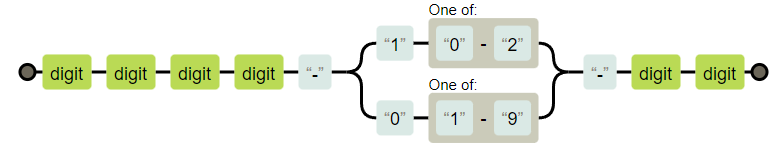

In [218]:
regex = '\d\d\d\d-(?:1[0-2]|0[1-9])-\d\d'
dirty_data[dirty_data.date.str.match(regex) != True]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
41,ORDB01380,Tue Dec 7 00:00:00 2021,19:19:26,Dinner,TP,"[('Salmon', 7), ('Shrimp', 4)]",503.0,-37.811679,144.964761,0,8.402,12.184178
112,ORDC10415,Thu Aug 12 00:00:00 2021,15:26:11,Lunch,NS,"[('Chicken', 1), ('Fries', 1), ('Steak', 2), (...",471.4,-37.824687,145.005827,0,11.165,16.741809
208,ORDZ03341,2021-14-09,16:27:02,Dinner,NS,"[('Pasta', 7), ('Fish&Chips', 2)]",262.5,-37.819808,144.974575,0,8.498,14.591980
226,ORDY03134,2021-31-08,15:56:37,Lunch,TP,"[('Steak', 8), ('Fries', 8), ('Salad', 9), ('C...",959.8,-37.814350,144.987079,0,9.642,13.311161
483,ORDX09025,2021-24-09,16:47:19,Dinner,BK,"[('Fish&Chips', 9), ('Shrimp', 9), ('Pasta', 3)]",883.5,-37.813887,144.955346,0,8.397,15.683569


As seen from above, there are even format with letter weekday, month by letter and also YYYY-DD-MM format in row 226. Then I decide to change the column date to date datatype so they can have the same format. 

In [219]:

# using panda to change column date to datetime type with argument dayfirst 
# as true to say that the priority format is YYYY-MM-DD
dirty_data['date'] = pd.to_datetime(dirty_data['date'], dayfirst = True)
# then change back to string data type
dirty_data['date'] = dirty_data['date'].astype(str)

dirty_data[dirty_data.date.str.match(regex) != True]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee


From above observation, the format is correct as there are not row has different format.

We can check if the date of the wrong rows above handled correct

In [220]:
dirty_data.iloc[[41, 112, 208, 226, 483], :]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
41,ORDB01380,2021-12-07,19:19:26,Dinner,TP,"[('Salmon', 7), ('Shrimp', 4)]",503.0,-37.811679,144.964761,0,8.402,12.184178
112,ORDC10415,2021-08-12,15:26:11,Lunch,NS,"[('Chicken', 1), ('Fries', 1), ('Steak', 2), (...",471.4,-37.824687,145.005827,0,11.165,16.741809
208,ORDZ03341,2021-09-14,16:27:02,Dinner,NS,"[('Pasta', 7), ('Fish&Chips', 2)]",262.5,-37.819808,144.974575,0,8.498,14.591980
226,ORDY03134,2021-08-31,15:56:37,Lunch,TP,"[('Steak', 8), ('Fries', 8), ('Salad', 9), ('C...",959.8,-37.814350,144.987079,0,9.642,13.311161
483,ORDX09025,2021-09-24,16:47:19,Dinner,BK,"[('Fish&Chips', 9), ('Shrimp', 9), ('Pasta', 3)]",883.5,-37.813887,144.955346,0,8.397,15.683569


As seen from above, all rows now have same format as YYYY-MM-DD. We can check other rows.

In [221]:
dirty_data.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDC02343,2021-09-17,16:37:10,Dinner,NS,"[('Salmon', 6), ('Shrimp', 7), ('Pasta', 5)]",761.5,-37.824761,144.988720,0,9.658,15.493916
1,ORDJ01024,2021-09-09,16:16:54,Dinner,TP,"[('Salmon', 8), ('Fish&Chips', 4)]",468.0,-37.823298,144.976371,0,8.140,12.373766
2,ORDK01604,2021-07-05,14:05:04,Lunch,BK,"[('Steak', 4), ('Fries', 7), ('Burger', 5), ('...",483.0,-37.800025,144.985956,0,6.336,12.691987
3,ORDI10356,2021-05-25,12:43:56,Lunch,NS,"[('Salad', 4), ('Fries', 6)]",140.8,-37.814918,144.982753,0,8.481,13.616527
4,ORDX02768,2021-12-26,19:49:51,Dinner,BK,"[('Pasta', 10), ('Shrimp', 6)]",599.0,-37.814828,144.932784,0,10.978,20.818866


The other rows that did not have errors before also have the same format.

<div class="alert alert-block alert-warning">

### 4.2. Order Type <a class="anchor" name="Type"></a>
    
</div>

As mentioned in the spec, there are three types of meals:
* Breakfast: 8am - 12pm
* Lunch: 12:00:01pm - 4pm
* Dinner: 4:00:01pm - 8pm

As we know that the time column is correct. We can check if the order type is correct as below.

Breakfast

In [222]:
dirty_data[(dirty_data.time >= "08:00:00") & (dirty_data.time <= "12:00:00")].order_type.value_counts()

Breakfast    151
Name: order_type, dtype: int64

Lunch

In [223]:
dirty_data[(dirty_data.time >= "12:00:01") & (dirty_data.time <= "16:00:00")].order_type.value_counts()

Lunch     177
Dinner      1
Name: order_type, dtype: int64

Dinner

In [224]:
dirty_data[(dirty_data.time >= "16:00:01") & (dirty_data.time <= "20:00:00")].order_type.value_counts()

Dinner       167
Breakfast      3
Lunch          1
Name: order_type, dtype: int64

As we can seen above, the order type of Lunch and Dinner has other order type. We need to fix it as below.

We check again if the order type is correct

In [225]:

for i in range(len(dirty_data)):
  # getting value time at row i
  time = dirty_data.at[i, "time"]
  meal_type = ""
  # condition as mentioned in the assignment specs 
  if time >= "08:00:00" and time <= "12:00:00":
    meal_type = "Breakfast"
  elif time >= "12:00:01" and time <= "16:00:00":
    meal_type = "Lunch"
  else:
    meal_type = "Dinner"
  # we only change the value if it is wrong
  if meal_type != dirty_data.at[i, "order_type"]:
    dirty_data.at[i, "order_type"] = meal_type


In [226]:
dirty_data[(dirty_data.time >= "08:00:00") & (dirty_data.time <= "12:00:00")].order_type.value_counts()

dirty_data[(dirty_data.time >= "12:00:01") & (dirty_data.time <= "16:00:00")].order_type.value_counts()

dirty_data[(dirty_data.time >= "16:00:01") & (dirty_data.time <= "20:00:00")].order_type.value_counts()

Dinner    171
Name: order_type, dtype: int64

All the order type are correct as seen above.

<div class="alert alert-block alert-warning">

### 4.3. Branch Code <a class="anchor" name="Branch"></a>
    
</div>

We can see from below that the branch_code has 5 unique values. Although there are only 3 branches from the branches dataset.

In [227]:
branches

,branch_name,branch_lat,branch_lon
branch_code,,,
NS,Nickolson,-37.773803,144.983647
TP,Thompson,-37.861835,144.905716
BK,Bakers,-37.815834,145.046450


In [228]:
dirty_data.describe(include=['O'])

,order_id,date,time,order_type,branch_code,order_items
count,500,500,500,500,500,500
unique,500,276,72,3,5,496
top,ORDC02343,2021-10-25,17:48:10,Lunch,TP,"[('Fish&Chips', 10), ('Shrimp', 4)]"
freq,1,5,14,178,167,2


As seen below, there are ns and tp which is in lowercase. We have to change it to uppercases.

In [229]:
# count values of each unique branch_code
dirty_data.branch_code.value_counts()

# apply str.upper function to branch_code column values to change 
# all the row value of branch_code to upper
dirty_data['branch_code'] = dirty_data['branch_code'].apply(str.upper)
dirty_data.branch_code.value_counts()

TP    168
NS    166
BK    166
Name: branch_code, dtype: int64

We also need to check if there is relationship between Order ID and branch_code. This might make sense as each branch_code might have different order_id syntax

In [230]:
dirty_data.head(10)

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDC02343,2021-09-17,16:37:10,Dinner,NS,"[('Salmon', 6), ('Shrimp', 7), ('Pasta', 5)]",761.50,-37.824761,144.988720,0,9.658,15.493916
1,ORDJ01024,2021-09-09,16:16:54,Dinner,TP,"[('Salmon', 8), ('Fish&Chips', 4)]",468.00,-37.823298,144.976371,0,8.140,12.373766
2,ORDK01604,2021-07-05,14:05:04,Lunch,BK,"[('Steak', 4), ('Fries', 7), ('Burger', 5), ('...",483.00,-37.800025,144.985956,0,6.336,12.691987
3,ORDI10356,2021-05-25,12:43:56,Lunch,NS,"[('Salad', 4), ('Fries', 6)]",140.80,-37.814918,144.982753,0,8.481,13.616527
4,ORDX02768,2021-12-26,19:49:51,Dinner,BK,"[('Pasta', 10), ('Shrimp', 6)]",599.00,-37.814828,144.932784,0,10.978,20.818866
5,ORDK06172,2021-07-25,14:45:38,Lunch,BK,"[('Salad', 5), ('Chicken', 7)]",310.00,-37.813127,144.951512,0,8.546,17.219538
6,ORDZ08681,2021-04-18,11:32:57,Breakfast,NS,"[('Coffee', 7), ('Cereal', 6), ('Pancake', 10)...",549.00,-37.823910,144.990186,0,9.633,16.686163
7,ORDX04013,2021-07-15,14:25:21,Lunch,BK,"[('Fries', 9), ('Chicken', 2), ('Burger', 1), ...",383.00,-37.819475,144.981763,0,6.596,12.318562
8,ORDI08234,2021-04-07,11:12:40,Breakfast,NS,"[('Eggs', 4), ('Cereal', 2), ('Pancake', 10), ...",374.00,-37.819248,144.946401,0,9.657,14.483786
9,ORDB10334,2021-01-26,08:50:42,Breakfast,TP,"[('Pancake', 5), ('Cereal', 8)]",271.25,-37.818102,144.931780,0,10.717,13.321566


We can see that the ID all start with ORD and with different letter then number. we can check if there is relationship between letter after ORD with the branch_code

In [231]:
# create set to store 4th letter of each order id corresponding to its branch
order_id = {}
order_id["TP"] = []
order_id["NS"] = []
order_id["BK"] = []
for i in range(len(dirty_data)):
  # get the branch_code to add to the set above
  branch_code = dirty_data.at[i, "branch_code"]
  # get the 4th letter of the order_id
  letter = dirty_data.at[i, "order_id"][3]
  # add to the set with corresponding branch
  order_id[branch_code].append(letter)

Counter(order_id["TP"])

Counter(order_id["NS"])

Counter(order_id["BK"])

Counter({'K': 55, 'X': 49, 'A': 61, 'Z': 1})

From above observations, we can see that there are some order id with 4th letter in each branch code that looks suspicious. From the above observations, there is a relationship between order id and the branch. There are some noise that we can fix. Below will be the correct 4th letter for each branch by looking at the number of order id (4th letter in order id with only 1 are more likely to be incorrect):

* TP: J, B, Y
* NS: C, I, Z
* BK: K, X, A

We can check more accurate from the outlier data as outlier data only contain outliers anomoly.

In [232]:
# resetting the set
order_id["TP"] = []
order_id["NS"] = []
order_id["BK"] = []
for i in range(len(outlier_data)):
  # get the branch_code to add to the set above (outlier_data)
  branch_code = outlier_data.at[i, "branch_code"]
  # get the 4th letter of the order_id
  letter = outlier_data.at[i, "order_id"][3]
  # add to the set with corresponding branch
  order_id[branch_code].append(letter)

Counter(order_id["TP"])

Counter(order_id["NS"])

Counter(order_id["BK"])

Counter({'K': 62, 'A': 56, 'X': 51})

From above observation from outlier data, we can conclude that our observation before is correct. We can see that each branch has different unique 4th letter in their order id. Then we can fix them by replacing the branch code by checking their order_id

First we initialize the correct 4th letter for each branch

In [233]:
correct_id = {}
correct_id["TP"] = set(order_id["TP"])
correct_id["NS"] = set(order_id["NS"])
correct_id["BK"] = set(order_id["BK"])

Then from the correct set above, we can check for each row of the dirty data and fix the error we saw above. From the specs, we know that the order_id column is error-free. So the branch_code column is wrong. Then we can go through each row then check the order_id. Then from order_id and correct_id set above, we can fix the branch_code

In [234]:
for i in range(len(dirty_data)):
  order_id = dirty_data.at[i, "order_id"]
  current_branch = dirty_data.at[i, "branch_code"]
  # 4th letter
  relationship = order_id[3]
  correct_code = ""
  # check to see the 4th letter in which branch_code form the correct_id set above
  for code in correct_id:
    # if it in the the set of correct id 
    if relationship in correct_id[code]:
      # then the current code is the correct code coresponding to the ORDER_ID
      correct_code = code
      break
  # if it is not the correct code then fix it
  if current_branch != correct_code:
    dirty_data.at[i, "branch_code"] = correct_code

We can check again if it work correctly.

In [235]:
order_id = {}
order_id["TP"] = []
order_id["NS"] = []
order_id["BK"] = []
for i in range(len(dirty_data)):
  branch_code = dirty_data.at[i, "branch_code"]
  letter = dirty_data.at[i, "order_id"][3]
  order_id[branch_code].append(letter)

Counter(order_id["TP"])

Counter(order_id["NS"])

Counter(order_id["BK"])

Counter({'K': 55, 'X': 49, 'A': 62})

From above check again, the error of branch_code is fixed.

<div class="alert alert-block alert-warning">

### 4.4. Order Item <a class="anchor" name="Item"></a>
    
</div>

<div class="alert alert-block alert-warning">

#### 4.4.1 Getting correct menu <a class="anchor" name="Menu"></a>
    
</div>

From the specs, we know that only the order id quantity is correct. So we have to check the items. Then we have to get the correct menu first. For the correct menu, we can get from the outlier_data.

In [236]:
def count_item(data):
  # separate to different order_type dataframe
  breakfast = data[data.order_type == "Breakfast"]
  lunch = data[data.order_type == "Lunch"]
  dinner = data[data.order_type == "Dinner"]

  all_b = ""
  all_l = ""
  all_d = ""
  # adding to string for applying regular expression
  for c in breakfast.order_items:
    all_b += c

  for c in lunch.order_items:
    all_l += c

  for c in dinner.order_items:
    all_d += c

  # get all the items which are follow pattern '(item)',
  all_b_list = re.findall(r"'(.+?)',", all_b)
  # breakfast
  b_occurence = Counter(all_b_list)

  all_l_list = re.findall(r"'(.+?)',", all_l)
  # lunch
  l_occurence = Counter(all_l_list)

  all_d_list = re.findall(r"'(.+?)',", all_d)
  # dinner
  d_occurence = Counter(all_d_list)
  return(b_occurence, l_occurence, d_occurence)

occurence = count_item(outlier_data)
print("Breakfast: \n", occurence[0])
print("Lunch: \n", occurence[1])
print("Dinner: \n", occurence[2])

Breakfast: 
 Counter({'Cereal': 135, 'Eggs': 134, 'Pancake': 128, 'Coffee': 124})
Lunch: 
 Counter({'Fries': 121, 'Steak': 113, 'Burger': 111, 'Salad': 104, 'Chicken': 102})
Dinner: 
 Counter({'Shrimp': 135, 'Fish&Chips': 129, 'Pasta': 125, 'Salmon': 125})


From above, we know that the correct menu for each order_type is:
* Breakfast: Cereal, Eggs, Pancake, Coffee
* Lunch: Fries, Steak, Burger, Salad, Chicken
* Dinner: Shrimp, , Fish&Chips, Pasta, Salmon

Then we have to check if there is any item in wrong order_type. We know that one row has only one error so we can check with order_type even if we fixed the order_type incorrectly.

<div class="alert alert-block alert-warning">

#### 4.4.2 Checking order_items of dirty_data <a class="anchor" name="item_dirty"></a>
    
</div>

In [237]:
dirty_occurence = count_item(dirty_data)
print("Breakfast: \n", dirty_occurence[0])
print("Lunch: \n", dirty_occurence[1])
print("Dinner: \n", dirty_occurence[2])

Breakfast: 
 Counter({'Cereal': 118, 'Pancake': 113, 'Eggs': 111, 'Coffee': 105, 'Pasta': 1, 'Chicken': 1, 'Steak': 1, 'Salmon': 1})
Lunch: 
 Counter({'Chicken': 128, 'Steak': 125, 'Salad': 125, 'Burger': 121, 'Fries': 109, 'Pancake': 1, 'Salmon': 1})
Dinner: 
 Counter({'Salmon': 129, 'Pasta': 125, 'Shrimp': 120, 'Fish&Chips': 117, 'Eggs': 1})


We can see that there are some incorrect items in the dirty data for all three meal type. We know that for those order with incorrect items. It only has that error because there is only error for each row. Thus, we know that its order price is correct for those row with incorrect items. So we can find the correct item from that order price. **But first we need to find the price for each items.**

<div class="alert alert-block alert-warning">

#### 4.4.3 Getting final menu with price <a class="anchor" name="Final_Menu"></a>
    
</div>

We can solve this by using linear system of equation. For example:

Cereal_Quantity * Cereal_Price + Eggs_Quantity * Egg_Price = Order_Price

We already know the quantity and the order_price. From that, we can calculate the price of each items by linear system of equation.

In [238]:
# getting the valid items for each order_type
valid = {}
valid["Breakfast"] = list(set(occurence[0]))
valid["Lunch"] = list(set(occurence[1]))
valid["Dinner"] = list(set(occurence[2]))

# a for solving linear system of equation
a_all = {}
a_all["Breakfast"] = []
a_all["Lunch"] = []
a_all["Dinner"] = []

# storing order_price for solving linear system of equation
b_all = {}
b_all["Breakfast"] = []
b_all["Lunch"] = []
b_all["Dinner"] = []

for i in range(len(dirty_data)):
  order = dirty_data.at[i, "order_items"]
  order_type = dirty_data.at[i, "order_type"]
  order_price = dirty_data.at[i, "order_price"]
  # the name to find correct position in the menu 
  order_name = re.findall(r"'(.+?)',", order)
  # order_quantity 
  order_quan = re.findall(r"(\d+)\)", order)
  
  # meal menu containing meal at certain order_type
  meal_menu = valid[order_type]
  # To store coefficient of the current row
  a = len(meal_menu) * [0]
  # going through ordered meals of current order_id
  for j in range(len(order_name)):
    # if the items in the correct menu
    if order_name[j] in meal_menu:
      # getting index of the order on meal_menu (Have to )
      index = meal_menu.index(order_name[j])
      # giving coefficient
      a[index] = int(order_quan[j])
  
  # store all a with its corresponding b 
  a_all[order_type].append(a)
  b_all[order_type].append(order_price)

After we got all a and its corresponding b. Then we have to solve linear system equation. However, there are some wrong data in order_price and order_items. Thus, we have to choose the best x for each order_type. We can find best x by counting with np.isclose between np.dot(a,x) with b. The best x will have the most correct.

In [239]:
best_x = {}
# x is the e price for each items with the corresponding order in the valid set 
best_x["Breakfast"] = []
best_x["Lunch"] = []
best_x["Dinner"] = []
for order_type in a_all:
  # get a of the order_type (e.g. Breakfast)
  a = np.array(a_all[order_type])
  # get b of the order_type
  b = np.array(b_all[order_type])
  # if there are 4 items in the current order_type then we also can only take 4
  # rows. So we have to get size from a.shape[1]
  size = a.shape[1]
  i = 0
  max_count = 0
  # loop until i + size > len(a)
  while (i+size) <= len(a):
    # we looping through each row then take rows from that i to i+size
    try:
      # calculat x with a and b 
      x = np.linalg.solve(a[i:(i+size)], b[i:(i+size)])
      
      # then we calculate number of close between dot product between a and 
      # current x with b. 
      count_true = sum(np.isclose(np.dot(a,x), b))

      # if the count number of close is larger than current max_count then
      # it mean current x is better than old x
      if count_true > max_count:
        # replace best x 
        best_x[order_type] = x
        # update the max count
        max_count = count_true

    # if it raise this error with Singular matrix error then it is due to the
    # row that has error in the dirty_data. For these error, we skip to the 
    # next row. I get this from stackoverflow [1] in the Reference part.
    except np.linalg.LinAlgError as err:
      if "Singular matrix" in str(err):
        pass
        # if it is other error then raise to check
      else:
        raise
    i += 1

best_x

{'Breakfast': array([21.  , 20.  , 22.25,  5.5 ]),
 'Lunch': array([12. , 45. , 17.2, 32. , 31. ]),
 'Dinner': array([35. , 54. , 27.5, 41. ])}

Above is the price with the corresponding items in the valid sets. We can combine valid and best_x for the final menu set.

In [240]:
final_menu = {}
for order_type in valid:
  items = valid[order_type]
  price = best_x[order_type]
  item_price = {}
  # get the items and mix it with its prices
  for i in range(len(items)):
    item_name = items[i]
    # round to 2 decimal place to follow the data format
    item_price[item_name] = round(price[i], 2)
  final_menu[order_type] = item_price

final_menu

{'Breakfast': {'Eggs': 21.0, 'Cereal': 20.0, 'Pancake': 22.25, 'Coffee': 5.5},
 'Lunch': {'Fries': 12.0,
  'Steak': 45.0,
  'Salad': 17.2,
  'Chicken': 32.0,
  'Burger': 31.0},
 'Dinner': {'Fish&Chips': 35.0, 'Shrimp': 54.0, 'Pasta': 27.5, 'Salmon': 41.0}}

Above is the final menu for each order type with its price. From above menu, we can get the correct order_items and order_price

<div class="alert alert-block alert-warning">

#### 4.4.4 Fix Order Items <a class="anchor" name="Order_Fix"></a>
    
</div>

First I create function to generate permutation of items that can be used to replace the items. For example, the incorrect row is 

\[('Cereal', 1), ('Pancake', 1), ('Chicken', 2), ('Salad', 4)]

If the order_type is Breakfast. Then Chicken and Salad are incorrect. Then we have to do permutation on the available items on the menus that are not Cereal, Pancake in this case. 

So the available items are Coffee and Eggs. However, there are two different quantity 2 and 4. Then we have to do permutation with available items with size 2. Then it is \[Coffee, Eggs] and \[Eggs, Coffee] to check all case to find correct order_item. If one of the cases has the price close to the order_price then that case is correct. As we know that one row has only one error so we know that the order_price is correct.

 The below function will help to do the permutation with available items that are not in the order_items yet. It will return the permutation of **index** of available items.

In [241]:
def possible_solution(the_menu, the_items, size):
  """
  the_menu: the menu with corresponding order_type
  the_items: the current order_items of one order_id
  size: number of items that is wrong
  """
  output =  []
  # go through menu
  for i in range(len(the_menu)):
    # only append if the items in the menu not already in provided the_items
    if the_menu[i] not in the_items:
      output.append(i)
  
  # permutations on the available items 
  output = list(permutations(output, size))
  return output

In [242]:
"""The below function will return the fixed order_items value in string type."""

def get_correct_item(my_items, my_quantity, my_price, my_menu):
  """
  my_items: current order_items of one order_id
  my_quantity: current quantity of one order_id
  my_price: current order_price of one order_id
  my_menu: the corresponding menu of current order_type
  """
  # my_menu currently have both the items and prices. I decide to separate them
  menu_items = list(my_menu)
  menu_prices = list(my_menu.values())
  # initialize a list for coefficient
  my_a = [0]*len(menu_items)
  # to store possible items (result of the permutation from above function)
  possible_item = []
  # the quantity of the items that got wrong before in current order_id
  possible_quan = []
  # count number of error for size of the permutation
  count_error = 0

  for i in range(len(my_items)):
    # if it in the menu then it is correct
    if my_items[i] in menu_items:
      # get the position of current items in the menu for putting in a
      pos = menu_items.index(my_items[i])
      # then put the coefficient into my_a[pos]
      my_a[pos] = int(my_quantity[i])
    else:
      # if it is not in the menu then it is wrong
      count_error += 1
      # put in the quantity of the wrong items
      possible_quan.append(int(my_quantity[i]))
    
  # getting permutation fo available items that not in the current order_items yet
  # the result is the index of the available items
  possible_item = possible_solution(menu_items, my_items, count_error)

  final_solution = []
  for solution in possible_item:
    # deep copy my_a for checking all case
    current_a = copy.deepcopy(my_a)
    # going through all possible solution
    for i in range(len(solution)):
        # put coefficient in the index of possible solutions
        current_a[solution[i]] = possible_quan[i]
    a_np = np.array(current_a)
    # check if the solution is close 
    # then break if it is close and it will be the final solution
    if np.isclose(np.dot(a_np, menu_prices), my_price) == True:
      final_solution = list(solution)
      break
  
  # change to string with same format
  final_string = "["
  for i in range(len(my_items)):
    # if the item is in the menu then take straight from my_items
    if my_items[i] in menu_items:
      if final_string != "[":
        elem = ", ('" + my_items[i] + "', " + my_quantity[i] + ")"
      else:
        elem = "('" + my_items[i] + "', " + my_quantity[i] + ")"
    # if not then take from final_solution
    else:
      position = final_solution.pop(0)
      correct_item = menu_items[position]
      if final_string != "[":
        elem = ", ('" + correct_item + "', " + my_quantity[i] + ")"
      else:
        elem = "('" + correct_item + "', " + my_quantity[i] + ")"
    final_string += elem
  final_string += "]"
  return final_string

In [243]:
"""Then we go through each row to check with above function"""

for i in range(len(dirty_data)):
  order = dirty_data.at[i, "order_items"]
  order_type = dirty_data.at[i, "order_type"]
  order_price = dirty_data.at[i, "order_price"]
  # getting items' name in pattern '(item)',
  order_name = re.findall(r"'(.+?)',", order)
  # getting items' quantity which are the digit only
  order_quan = re.findall(r"(\d+)\)", order)

  # get correct values
  correct_order = get_correct_item(order_name, order_quan, order_price, final_menu[order_type])
  
  # check position of wrong items if it exists
  if correct_order != dirty_data.at[i, "order_items"]:
    print("Wrong at index: " + str(i))
    print("Order type:", order_type)
    print("Old order:", dirty_data.at[i, "order_items"])
    print("Fixed order:", correct_order)
    print('________________________________________________________________')
    dirty_data.at[i, "order_items"] = correct_order

"""As seen above, the items fixed correctly with correct locations. We can check again if all the order items in the correct order_type."""

dirty_occurence = count_item(dirty_data)
print("Breakfast: \n", dirty_occurence[0])
print("Lunch: \n", dirty_occurence[1])
print("Dinner: \n", dirty_occurence[2])

Wrong at index: 47
Order type: Breakfast
Old order: [('Cereal', 4), ('Coffee', 4), ('Pasta', 10)]
Fixed order: [('Cereal', 4), ('Coffee', 4), ('Pancake', 10)]
________________________________________________________________
Wrong at index: 74
Order type: Breakfast
Old order: [('Cereal', 7), ('Eggs', 4), ('Chicken', 10), ('Coffee', 5)]
Fixed order: [('Cereal', 7), ('Eggs', 4), ('Pancake', 10), ('Coffee', 5)]
________________________________________________________________
Wrong at index: 237
Order type: Dinner
Old order: [('Fish&Chips', 5), ('Shrimp', 4), ('Eggs', 10)]
Fixed order: [('Fish&Chips', 5), ('Shrimp', 4), ('Pasta', 10)]
________________________________________________________________
Wrong at index: 240
Order type: Lunch
Old order: [('Fries', 1), ('Steak', 3), ('Pancake', 7)]
Fixed order: [('Fries', 1), ('Steak', 3), ('Burger', 7)]
________________________________________________________________
Wrong at index: 376
Order type: Breakfast
Old order: [('Steak', 10), ('Eggs', 9)]

From above, The items are all in correct order_type.

<div class="alert alert-block alert-warning">

### 4.5. Order Price <a class="anchor" name="Order_Price"></a>
    
</div>

As we has the final menu and correct order_items. We can now find the correct order_price by dot product. We will replace the order_price if it is not close to the result. The dot product is as below for example \[('Cereal', 4), ('Coffee', 4), ('Pancake', 10)]. From the menu, we can get price of cereal as 20, Coffee as 5.5 and Pancake as 10. Then we have:

Correct Order Price = 4 x 20 + 4 x 5.5 + 10 x 22.25

Then we can check if the correct order price close to the order_price value.

In [244]:
for i in range(len(dirty_data)):
  order_type = dirty_data.at[i, "order_type"]
  order_price = dirty_data.at[i, "order_price"]
  order_items = dirty_data.at[i, "order_items"]
  # getting items' name in pattern '(item)',
  items = re.findall(r"'(.+?)',", order_items)
  # getting items' quantity which are the digit only
  quantity = re.findall(r"(\d+)\)", order_items)
  # get menu from the current order_type
  meal_menu = valid[order_type]
  # initialize a 
  a = len(meal_menu) * [0]
  x = best_x[order_type]

  for j in range(len(items)):
    # get the position of the item in meal menu
    index = meal_menu.index(items[j])
    # put the coefficient in that position
    a[index] = int(quantity[j])

  # check if the dot product is close to the order_price
  if np.isclose(np.dot(a, x), order_price) == False:
    print("Wrong at index: " + str(i))
    print("Old price:",order_price)
    print("Fixed price:", round(np.dot(a,x), 2))
    print('____________________')
    dirty_data.at[i, "order_price"] = round(np.dot(a,x), 2)

Wrong at index: 35
Old price: 363.0
Fixed price: 407.25
____________________
Wrong at index: 36
Old price: 1064.8
Fixed price: 182.0
____________________
Wrong at index: 244
Old price: 468.0
Fixed price: 276.25
____________________
Wrong at index: 310
Old price: 253.5
Fixed price: 407.2
____________________
Wrong at index: 350
Old price: 567.0
Fixed price: 433.8
____________________
Wrong at index: 395
Old price: 807.0
Fixed price: 311.0
____________________
Wrong at index: 403
Old price: 585.0
Fixed price: 305.25
____________________


At above locations, we fix the order_price.

<div class="alert alert-block alert-warning">

### 4.6. Customer Lat and Customer Long <a class="anchor" name="Location"></a>
    
</div>

We check the range of customer_lat and customer_lon. We can see below that the min of bot customer_lat and customer_lon is negative values. The maximum of both are positive values.

In [245]:
dirty_data.describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,475.481200,-35.379837,143.138876,0.072000,8.756648,13.822887
std,251.957758,19.358275,18.204542,0.258747,1.679507,2.598111
min,42.250000,-37.834290,-37.818945,0.000000,3.234000,5.050452
25%,287.187500,-37.819105,144.949794,0.000000,7.713500,12.692750
50%,432.750000,-37.813134,144.963997,0.000000,8.870000,14.037692
75%,626.500000,-37.806321,144.982430,0.000000,9.812000,15.316775
max,1423.000000,145.012522,145.017855,1.000000,13.054000,22.184617


However, to get the distance to customer, the customer_lat and customer_lon must be in the node files as we generate the graphs from that. Then to check if the customer_lat and customer_lon is correct then we check in the nodes dataset.

In [246]:
nodes.describe()

,node,lat,lon
count,1.711700e+04,17117.000000,17117.000000
mean,2.023147e+09,-37.812451,144.966743
std,1.978621e+09,0.008005,0.021438
min,2.157811e+07,-38.110916,144.654172
25%,4.888793e+08,-37.818767,144.951965
50%,8.465677e+08,-37.812767,144.964104
75%,3.215192e+09,-37.806185,144.981581
max,6.282174e+09,-37.739636,145.046450


We can see that in the nodes dataset that the min lat is negative value but min lon is positive value. On the other hand, the maximum value in lat is negative. Which mean the range of customer_lat and customer_lon in dirty data is wrong. We can check row that has wrong customer_lat and customer_lon as below.

In [247]:
dirty_data[(dirty_data.customer_lat > 0) | (dirty_data.customer_lon <= 0)]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
34,ORDA01826,2021-04-18,11:32:57,Breakfast,BK,"[('Pancake', 8), ('Coffee', 10), ('Eggs', 7), ...",440.00,37.819667,144.979626,0,7.202,14.620028
42,ORDY00328,2021-03-29,10:52:23,Breakfast,TP,"[('Coffee', 8), ('Pancake', 9), ('Cereal', 8),...",446.25,145.005773,-37.812619,0,11.491,13.480959
72,ORDZ08143,2021-06-12,13:24:30,Lunch,NS,"[('Salad', 2), ('Fries', 1), ('Steak', 4), ('C...",514.40,37.824230,144.984256,0,9.519,17.312180
185,ORDA02310,2021-10-23,17:48:10,Dinner,BK,"[('Salmon', 5), ('Pasta', 4), ('Fish&Chips', 4)]",455.00,145.012522,-37.812571,0,3.665,12.984344
196,ORDB09642,2021-12-03,19:09:17,Dinner,TP,"[('Salmon', 5), ('Pasta', 9)]",452.50,145.004460,-37.805485,0,11.964,15.656461
291,ORDK01381,2021-02-15,09:31:16,Breakfast,BK,"[('Coffee', 2), ('Pancake', 2)]",55.50,37.823318,145.009236,0,4.730,9.358317
332,ORDA10695,2021-05-14,12:23:39,Lunch,BK,"[('Fries', 4), ('Salad', 5), ('Steak', 1), ('C...",403.00,144.957364,-37.813743,0,8.133,13.155919
441,ORDB03010,2021-06-28,13:54:55,Lunch,TP,"[('Burger', 3), ('Salad', 7), ('Chicken', 3)]",309.40,144.946680,-37.818945,0,9.170,12.257562
456,ORDC10589,2021-06-06,13:04:13,Lunch,NS,"[('Burger', 5), ('Steak', 9), ('Salad', 1)]",577.20,37.807219,144.957056,0,8.130,15.736768


As seen above, I have come to conclusion that there are following error type in customer_lat and customer_lon:
* the customer_lat and customer_lon correct values are swapped around (e.g. row 42)
* customer_on is correct but customer_lat has wrong sign

We can fix by below codes

In [248]:
for i in range(len(dirty_data)):
  # get the customer_lat value at row i
  lat = dirty_data.at[i, 'customer_lat']
  # get the customer_lon value at row i
  lon = dirty_data.at[i, 'customer_lon']
  # If customer_lat is wrong but customer_lon is correct
  if lat > 0 and lon > 0:
    # then change the sign of customer_lat to negative
    dirty_data.at[i, 'customer_lat'] = lat * (-1)
  # If customer_lat is true but customer_lon is incorrect 
  elif lon < 0 and lat < 0:
    # then change the sign of customer_lon to positive
    dirty_data.at[i, 'customer_lon'] = lon * (-1)
  # if both are wrong then it should be swapped
  elif lat > 0 and lon < 0:
    dirty_data.at[i, 'customer_lat'] = lon
    dirty_data.at[i, 'customer_lon'] = lat

"""Then we can see that it is fixed as below."""

len(dirty_data[(dirty_data.customer_lat > 0) | (dirty_data.customer_lon <= 0)])

0

<div class="alert alert-block alert-warning">

### 4.7. Distance to Customer <a class="anchor" name="Distance"></a>
    
</div>

Creating graph for simulating map by nx library


In [249]:
graph = nx.Graph()
all_edges = []

# add edge to all_edges from edges dataset
for i in range(len(edges)):
  u = edges.at[i, "u"]
  v = edges.at[i, "v"]
  weight = edges.at[i, "distance(m)"]
  # edge format as below 
  edge = (u,v, {'weight':weight})
  all_edges.append(edge)

# add node to the graph first from node dataset
for i in range(len(nodes)):
  graph.add_node(nodes.at[i, "node"])

# add edges
graph.add_edges_from(all_edges)

"""For current branches dataframe. There are only lat and long with its branch_code. So I decide to get its node number to this dataframe for ease of work."""

branches

# creating new columns to branches dataframe
branches['node'] = 0
for branch in branches.index:
  for i in range(len(nodes)):
    # give node number to the branch with its corresponding lat and long
    if branches.at[branch, "branch_lat"] == nodes.at[i, "lat"] and branches.at[branch, "branch_lon"] == nodes.at[i, "lon"]:
      branches.at[branch, "node"]  = nodes.at[i, "node"]
      break


Then we use Dijktra algorithm from nx package to find the shortest distance. Then we use that calculated distance to check if there is error in distance column and fix it at the same time.

In [250]:
for i in range(len(dirty_data)):
  lat = dirty_data.at[i, "customer_lat"]
  lon = dirty_data.at[i, "customer_lon"]
  branch = dirty_data.at[i, "branch_code"]
  old_distance = dirty_data.at[i, "distance_to_customer_KM"]

  # getting the start which is the node of current branch
  start = branches.at[branch, "node"]
  target = ""
  # finding target from customer_lat and customer_lon in nodes dataset
  for j in range(len(nodes)):
    if lat == nodes.at[j, "lat"] and lon == nodes.at[j, "lon"]:
      target = nodes.at[j, "node"]
      break

  # use Dijkstra in nx to find shortest distance
  correct_distance = nx.shortest_path_length(graph, start, target, weight='weight')
  # as the distance in the graph currently is meter so we have to change to km
  correct_distance = round(correct_distance * 0.001, 3)
  if correct_distance != old_distance:
    print("Wrong at position:", i)
    print("Wrong distance:", old_distance)
    print("Fixed distance:", correct_distance)
    print("_______________________")
    dirty_data.at[i, "distance_to_customer_KM"] = correct_distance

Wrong at position: 10
Wrong distance: 9.645
Fixed distance: 9.637
_______________________
Wrong at position: 19
Wrong distance: 9.297
Fixed distance: 9.67
_______________________
Wrong at position: 27
Wrong distance: 8.901
Fixed distance: 9.403
_______________________
Wrong at position: 37
Wrong distance: 10.111
Fixed distance: 7.619
_______________________
Wrong at position: 73
Wrong distance: 8.887
Fixed distance: 8.523
_______________________
Wrong at position: 97
Wrong distance: 8.282
Fixed distance: 9.637
_______________________
Wrong at position: 180
Wrong distance: 9.597
Fixed distance: 6.461
_______________________
Wrong at position: 293
Wrong distance: 9.812
Fixed distance: 10.574
_______________________
Wrong at position: 425
Wrong distance: 7.119
Fixed distance: 8.995
_______________________


Above are the rows that got wrong distance. The distance is then fixed to Fixed distance print value.

<div class="alert alert-block alert-warning">

### 4.8. Loyalty Check <a class="anchor" name="Loyalty"></a>
    
</div>

Lastly, we have to check if the customer actually has loyalty or not. For this part, we have to find the deliver fee by Linear Regression model and then compare with the delivery_fee (error-free column) to know if the customer has loyalty or not. If they have loyalty then the price should be half.

Each branch has different linear model and we cannot take from outlier data as there are outlier in delivery_fee in outlier dataset. Thus we can train model on missing data.

Below function is used to generate train data or test data for Linear Regression model. It will only select the required columns and also generate the required columns like day time and weekend for the linear regression.

As the fee depends linearly on:
* weekend or weekday (1 or 0)
* time of the day (morning 0, afternoon 1, evening 2)
* distance between branch and customer

We need to check weekend or weekday from the date column and time of the day from the order_type. Which Breakfast is morning (0), Lunch is afternoon (1) and Dinner as evening (2). We also have to reset the delivery fee to its double price without discount to train correctly.

In [251]:
def get_data(data, train, missing):
  # make copy of data
  final_data = pd.DataFrame(data)
  # select only required columns for following steps
  final_data = final_data[["date", "order_type", "branch_code", "customerHasloyalty?", "distance_to_customer_KM", "delivery_fee"]]
  # create columns weekend and day_time for linear regression
  final_data["weekend"] = 1
  final_data["day_time"] = 0

  # if the data has missing values then drop na and reset the index
  if missing:
    final_data = final_data.dropna().reset_index()
  
  for i in range(len(final_data)):
    # change to datetime data type for using function weekday()
    date = pd.to_datetime(final_data.at[i, "date"], dayfirst = True)
    day = date.weekday()

    # weekday() return number as 5 and 6 as Saturday and Sunday. 
    # Lower would be weekday
    if day < 5:
      final_data.at[i, "weekend"] = 0

    # if this is the train data then we have to double price for delivery fee
    # for customer that has loyalty to train model
    # the test data does not need to double the price
    if train:
      loyalty = final_data.at[i, "customerHasloyalty?"]
      if loyalty == 1:
        fee = final_data.at[i, "delivery_fee"] * 2
        final_data.at[i, "delivery_fee"] = fee

    # get value for day_time with 0 for morning, 1 for afternoon, 2 for evening
    order_type = final_data.at[i, "order_type"]
    if order_type == "Breakfast":
      final_data.at[i, "day_time"] = 0
    elif order_type == "Lunch":
      final_data.at[i, "day_time"] = 1
    else:
      final_data.at[i, "day_time"] = 2
  
  # if missing then drop index column as the result of reset_index above
  if missing:
    final_data = final_data.drop(["date", "customerHasloyalty?", "index", "order_type"], axis = 1)
  # if not then drop the columns we do not need anymore for train model
  else:
    final_data = final_data.drop(["date", "customerHasloyalty?", "order_type"], axis = 1)

  return final_data

Then we train the data and check the model performance. As mentioned in the specs, each branch has different model so we have to train different model on different branch.

Below function use to split the train data into train data and test data for calculating R squared for check the fit of the model.

In [252]:
def train_model(train):
  # split train data and model to each branch
  branch_train = {}
  linear_model = {}

  branch_train["NS"] = train[train.branch_code == "NS"]
  linear_model["NS"] = LinearRegression()

  branch_train["BK"] = train[train.branch_code == "BK"]
  linear_model["BK"] = LinearRegression()

  branch_train["TP"] = train[train.branch_code == "TP"]
  linear_model["TP"] = LinearRegression()

  for branch in branch_train:
    x = branch_train[branch]
    # train_test_split will split data to train and test data 
    X_train, X_test, y_train, y_test = train_test_split(x[["day_time", "distance_to_customer_KM", "weekend"]].copy(),x[["delivery_fee"]].copy(), random_state=111)
    # train the model 
    linear_model[branch].fit(X_train, y_train)
    # test the model score
    print("R squared score:", branch, linear_model[branch].score(X_test, y_test))

  # train the model again with full data
  for branch in train_branch:
    # get train data with corresponding branch
    x = branch_train[branch]
    train_x = x[["day_time", "distance_to_customer_KM", "weekend"]].copy()
    train_y = x[["delivery_fee"]].copy()
    # train model of each branch
    linear_model[branch] = LinearRegression()
    linear_model[branch].fit(train_x, train_y)

  return (branch_train, linear_model)

# the data is for train and has missing data so we put true for both
train_data = get_data(missing_data, True, True)

train_branch = {}
model = {}
train_branch, model = train_model(train_data)

R squared score: NS 0.9543167584187454
R squared score: BK 0.9895977966290485
R squared score: TP 0.9581005340621644


We have very high R square score. So we can rely on these models. Then we train on the full train data again without spliting.

In [253]:
test_data = get_data(dirty_data, False, False)

From the model, we predict for each row then also calculate the half price. Then we check if the delivery_fee near half price or the original price. If it near half price then loyalty must be 1 and 0 otherwise. We can check which one nearer by substraction. If delivery_fee - half_price > delivery_fee - original_price then it means the loyalty is 0. It is 1 for opposite case. 

In [254]:
# select only column which are features
x = test_data[["day_time", "distance_to_customer_KM", "weekend"]].copy()
for i in range(len(test_data)):
  branch = test_data.at[i, "branch_code"]
  delivery_fee = test_data.at[i, "delivery_fee"]
  # get only one row as data so we have to use .T to transpose
  current_x = pd.DataFrame(x.iloc[i,:]).T
  # predict on the current x with the trained model
  prediction = model[branch].predict(current_x)[0][0]
  # calculate the half price
  half_price = prediction / 2
  
  # if original price without discount near the delivery fee more then loyal is 0
  if abs(delivery_fee - half_price) > abs(delivery_fee - prediction):
    true_loyalty = 0
  # if half price near delivery fee more then loyal is 1
  else:
    true_loyalty = 1

  # check if the loyal is correct or not
  if dirty_data.at[i, "customerHasloyalty?"] != true_loyalty:
    print("Wrong position at", i)
    print("Correct fee:",delivery_fee)
    print("predict:",prediction)
    print("half price prediction", half_price)
    print("wrong loyalty:",dirty_data.at[i, "customerHasloyalty?"])
    print("fixed:",true_loyalty)
    print("_______________________________________")
    dirty_data.at[i, "customerHasloyalty?"] = true_loyalty

Wrong position at 63
Correct fee: 13.0485807
predict: 12.640900086541654
half price prediction 6.320450043270827
wrong loyalty: 1
fixed: 0
_______________________________________
Wrong position at 84
Correct fee: 14.3876873
predict: 14.306978010497879
half price prediction 7.1534890052489395
wrong loyalty: 1
fixed: 0
_______________________________________
Wrong position at 128
Correct fee: 13.2729347
predict: 12.74754190868057
half price prediction 6.373770954340285
wrong loyalty: 1
fixed: 0
_______________________________________
Wrong position at 189
Correct fee: 12.0134982
predict: 12.075358110825821
half price prediction 6.0376790554129105
wrong loyalty: 1
fixed: 0
_______________________________________
Wrong position at 229
Correct fee: 15.6122008
predict: 15.70965842415508
half price prediction 7.85482921207754
wrong loyalty: 1
fixed: 0
_______________________________________
Wrong position at 326
Correct fee: 15.4306931
predict: 14.891662711074025
half price prediction 7.44583

Above show position that got wrong loyalty. We can see that error only happen for loyalty 1 as they should not be loyalty customer as they have the original delivery price and not the discount price.

<div class="alert alert-block alert-warning">

### 4.9. Writting Dirty Data <a class="anchor" name="Writing_Dirty"></a>
    
</div>

After we have identified and fixed the error, we write it to *29376629_dirty_data_solution.csv

In [255]:
dirty_data.to_csv('dirty_data_solution.csv')

<div class="alert alert-block alert-warning">

## 5. Outlier Data <a class="anchor" name="Outlier"></a>
    
</div>

Then we move on to the outlier data which have outlier in the delivery fee.

<Axes: >

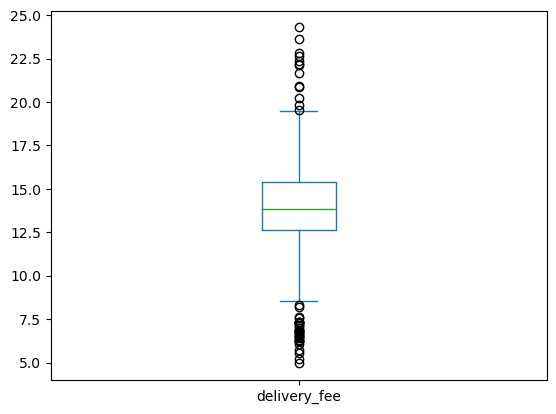

In [256]:
outlier_data["delivery_fee"].plot(kind='box')

From above observation, we can see that there are a lot of outliers. However, this is not the univariate outliers problem as delivery fee is related to **weekday or weekend**, **time of the day** and **distance to customer**. Moreover, it also depend on the whether they have loyalty or not for having discount. Thus, we have to use Multivariate Regression Residual Analysis for this task to solve multivariate problem.

The residual can be calculated as below:

***residual =  data delivery fee - predicted delivery fee***

Then we have to remove the outlier by looking at the outlier of the residual. That is how we gonna use Multivariate Regression Residual Analysis for removing outlier of multivariate problem.

We will train the model on outlier data first.

R squared score: NS 0.5566044376945439
R squared score: BK 0.5596299312219506
R squared score: TP 0.20847985740088049


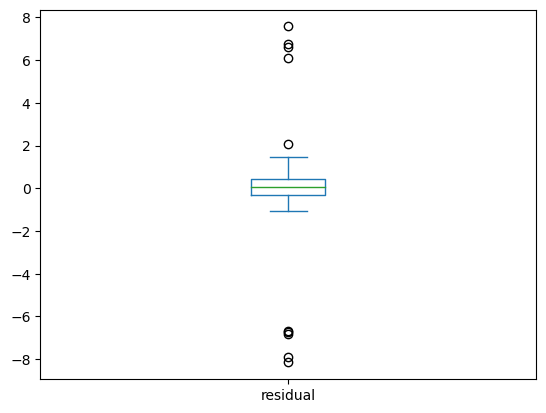

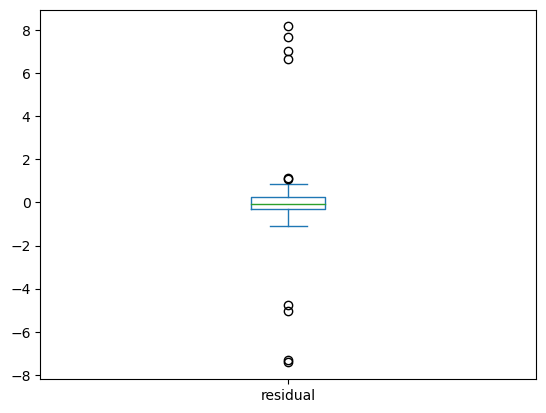

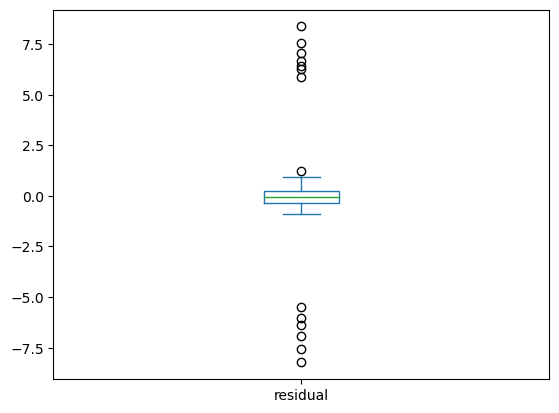

In [257]:
# the data is for train and does not have missing data so we put true and false
train_data = get_data(outlier_data, True, False)

# calculate R squared of each model again
train_branch, model = train_model(train_data)

"""As seen above, the R squared of each branches are very low. The model cannot cover over 90% of the data. This is due to the outliers in the delivery_fee column. Now we will train the data again and predict it. Then we need to calculate the residual to plot the outlier of the residual. """

prediction = {}
residual = {}

# each branch have different models
for branch in train_branch:
  x = train_branch[branch]
  # splitting into x and y for training
  train_x = x[["day_time", "distance_to_customer_KM", "weekend"]].copy()
  train_y = x[["delivery_fee"]].copy()
  # reset the model 
  model[branch] = LinearRegression()
  # fit the train data 
  model[branch].fit(train_x, train_y)
  # use the model just trained to predict on train data x 
  prediction[branch] = model[branch].predict(train_x)
  # calculate the residual 
  residual[branch] = train_y - prediction[branch]
  # we change the name of delivery fee to residual just for clear
  residual[branch] = residual[branch].rename(columns= {"delivery_fee": "residual"})
  # boxplot the residual for each branch
  residual[branch].plot(kind='box')

As seen above, we can see that there are outliers in the residual for all 3 branches. Then we need to create function to remove the outliers from the residual for each branch model. For this function, I base on the function from GeeksforGeeks \[3].

In [258]:
def get_outliers(my_df):
  # we find Q1 and Q3 by np then from that we can also calculate IQR
  Q1 = np.quantile(my_df, 0.25)
  Q3 = np.quantile(my_df, 0.75)
  IQR = Q3 - Q1
  # calcualte upper and lower bound
  upper = Q3 + (1.5*IQR)
  lower = Q1 - (1.5*IQR)
  # then the outliers are rows that got residual value out of bounds
  outliers = my_df[(my_df["residual"] <= lower) | (my_df["residual"] >= upper)]
  return outliers

all_outliers = {}
for branch in residual:
  # remove outliers from outlider data by get index of the outliers 
  outlier_data = outlier_data.drop(list(get_outliers(residual[branch]).index))
  # we do the same for residual data to plot again
  residual[branch] = residual[branch].drop(list(get_outliers(residual[branch]).index))

We then plot again to see if there are still many outliers or not.

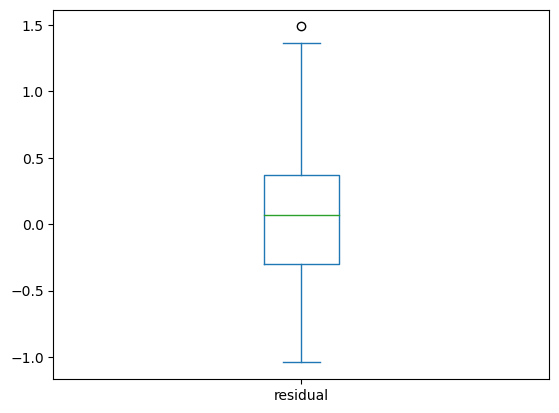

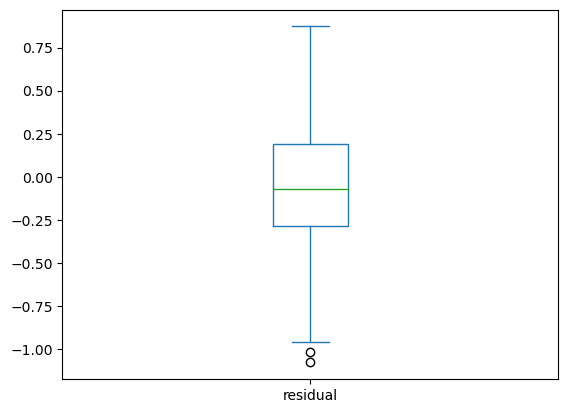

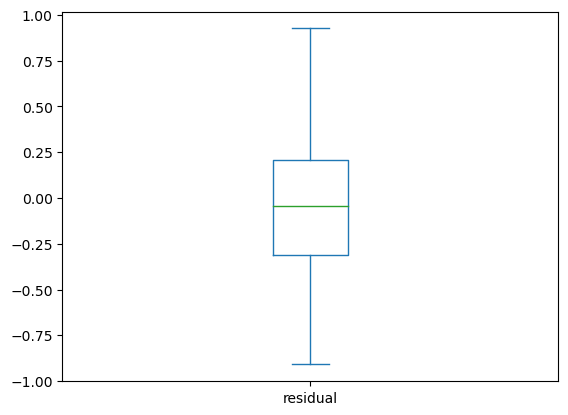

In [259]:
for branch in train_branch:
  residual[branch].plot(kind='box')

We can see that the outliers are reduced significantly. We can check if the prediction also improved after the outliers are removed. 

In [260]:
# outlier data after got outlier removed, we have to reset the index to loop
train_data = get_data(outlier_data.reset_index(), True, False)

# calculate R squared of each model again
train_branch, model = train_model(train_data)

R squared score: NS 0.9107561003947656
R squared score: BK 0.9786826192118583
R squared score: TP 0.9343891461644575


We can see that the R squared score is much higher than before removing outliers.

<div class="alert alert-block alert-warning">

### Writting to files <a class="anchor" name="Writting_Outlier"></a>
    
</div>

In [261]:
outlier_data.to_csv('outlier_data_solution.csv')

<div class="alert alert-block alert-warning">

## 6. Missing Data <a class="anchor" name="Missing"></a>
    
</div>

Now we will handle the missing data. We have to impute the NA values of the missing data but not remove it. First, we need to see which columns has the missing values.

In [262]:
missing_data.isnull().sum()

order_id                     0
date                         0
time                         0
order_type                   0
branch_code                 50
order_items                  0
order_price                  0
customer_lat                 0
customer_lon                 0
customerHasloyalty?          0
distance_to_customer_KM      0
delivery_fee               100
dtype: int64

From above, we can see that there are missing values in branch_code column and delivery_fee column. Fortunately, we got the correct code set for each branch when we cleaning the data in the dirty data set. We can do the same for missing data as we did with dirty data.

First, we need to create the missing dataframe which

In [263]:
# missing dataframe with isnull() function which will return true and false if there is null values
miss = pd.DataFrame(missing_data['branch_code'].isnull())
miss.head()

,branch_code
0,False
1,False
2,False
3,False
4,False


We then use miss dataframe to impute missing value to the na values.

In [264]:
for i in range(len(missing_data)):
  # get the order_id
  order_id = missing_data.at[i, "order_id"]
  # get the 4th letter of order_id
  relationship = order_id[3]
  correct_code = ""
  # if there is missing value at current index
  if miss.at[i, "branch_code"]:
    # check which branch code this order_id belong to
    for code in correct_id:
      if relationship in correct_id[code]:
        correct_code = code
        break
    # impute the value
    missing_data.at[i, "branch_code"] = correct_code

missing_data.isnull().sum()

order_id                     0
date                         0
time                         0
order_type                   0
branch_code                  0
order_items                  0
order_price                  0
customer_lat                 0
customer_lon                 0
customerHasloyalty?          0
distance_to_customer_KM      0
delivery_fee               100
dtype: int64

As seen above, all the NA values in branch_code columns have been imputed. Now, we have to deal with na value in delivery_fee column. To impute the most accurate value, I will use all the rows that does not have missing data and combining with outlier data then dirty data. We can do this after the outlier is removed from outlier data and error is fixed in dirty data. We use that data to train the model for Linear Regression model. Then we use that model to predict the delivery values from day time, weekend or weekday and distance to customer.

In [265]:
# concat all data 
all_data = [missing_data.copy(), outlier_data.copy(), dirty_data.copy()]

# this is the train data and we have missing data so we have to put True for both arguments
train_data = get_data(pd.concat(all_data), True, True)

# train the model and also check R squared for each model
train_branch, model = train_model(train_data)

R squared score: NS 0.9491908976447534
R squared score: BK 0.9808720054654461
R squared score: TP 0.9551399535436368


We can see that the R squared scores are very high so we can rely on these models to impute the NA values in our missing data.

In [266]:


# set up the test data 
test_data = get_data(missing_data, False, False)

# getting the features for model
x = test_data[["day_time", "distance_to_customer_KM", "weekend"]].copy()
# same thing we did for branch_code
miss = pd.DataFrame(missing_data['delivery_fee'].isnull())

for i in range(len(test_data)):
  # if there is null value
  if miss.at[i, "delivery_fee"]:
    branch = test_data.at[i, "branch_code"]
    # get only one row as data for prediction so we have to use .T to transpose
    current_x = pd.DataFrame(x.iloc[i,:]).T
    # predict on the current x with the trained model
    prediction = model[branch].predict(current_x)[0][0]
    # if customer has loyalty then we have to give 50% discount
    if missing_data.at[i, "customerHasloyalty?"] == 1:
      prediction = prediction / 2
    # impute the values
    missing_data.at[i, "delivery_fee"] = prediction

# check if all the null imputed
missing_data.isnull().sum()

order_id                   0
date                       0
time                       0
order_type                 0
branch_code                0
order_items                0
order_price                0
customer_lat               0
customer_lon               0
customerHasloyalty?        0
distance_to_customer_KM    0
delivery_fee               0
dtype: int64

All the missing values are imputed. Now, we will write to solution file.

In [267]:
missing_data.to_csv('missing_data_solution.csv')

<div class="alert alert-block alert-warning">

## 7. Summary and observation <a class="anchor" name="Summary"></a>
    
</div>

From this project, I think handling dirty data is very challenging and take longer than I expected. I might not find out the relationship between order Id and branch code if there is no null value in missing data. Due to the missing data in branch code, I have to find if there is any columns related to the branch code. Therefore, the error might be very easy to miss out if we do not check carefully. 

For outlier data, it is very interesting to find out about the aspect of the multivariate outliers problem. This is very helpful for removing outliers of other model type as well. 

For missing data, it show how useful machine learning model as we can impute the missing data depending on the existed data we got. 

This assignment has helped me a lot for my data wrangling skills.

# Reference

\[1] GeeksForGeeks. (2022). *Permutation and Combination in Python*. retrieved from:

https://www.geeksforgeeks.org/permutation-and-combination-in-python/

\[2] Handling Illegal Matrix Operation.

https://stackoverflow.com/questions/9155478/how-to-try-except-an-illegal-matrix-operation-due-to-singularity-in-numpy

\[3] GeeksForGeeks. (2021). *Finding the outlier points from Matplotlib*. Retrieved from:

https://www.geeksforgeeks.org/finding-the-outlier-points-from-matplotlib/
